# NBA recommendation engine

### URLs
- https://github.com/swar/nba_api/tree/master/docs/nba_api/stats/endpoints
- https://github.com/seemethere/nba_py/wiki/stats.nba.com-Endpoint-Documentation#parameters-39
- https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/commonplayerinfo.md

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import requests
from bs4 import BeautifulSoup
import copy
import matplotlib.ticker as mtick
import time
from collections import Counter
from fuzzywuzzy import fuzz

#%pylab
import mplcursors

In [2]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import commonplayerinfo
from nba_api.stats.static import teams
from nba_api.stats.endpoints import playercareerstats

# Load data

In [3]:
players_data = pd.read_csv('players_data.csv').sort_values(by=['id']).reset_index(drop = True)
players_salaries = pd.read_csv('players_salaries.csv').sort_values(by=['id'])
players_stats_agg = pd.read_csv('playercareerstats_agg.csv').sort_values(by=['PLAYER_ID']) # gewichtete Durchschnitte der letzten 3 Saisons: 1/3, 2/3, 3/3
players_stats = pd.read_csv('playercareerstats.csv').sort_values(by=['PLAYER_ID'])

teams_data = pd.read_csv('teams_data.csv')
teams_salaries = pd.read_csv('teams_salaries.csv')

## Optional: change weights for aggregating seasonal data

In [4]:
w = [7/10, 2/10, 1/10]

In [5]:
players_stats = players_stats[(players_stats['SEASON_ID'] == '2020-21') | 
                              (players_stats['SEASON_ID'] == '2019-20') | 
                              (players_stats['SEASON_ID'] == '2018-19')].reset_index().drop(columns=['index'])

In [6]:
# get data per game

col_div = ['MIN', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL',
           'BLK', 'TOV', 'PF', 'PTS']
col_idx =  [list(players_stats.columns).index(i) for i in col_div]

for i in range(players_stats.shape[0]):
    n_games = players_stats["MIN"][i] #  per 'GP' or per 'MIN'?
    for j in col_idx:
        players_stats.iloc[i, j] /= n_games 
    
display(players_stats.head())

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,2544,2018-19,0,1610612747,LAL,34.0,55,55,1.0,0.288074,...,0.665,0.029427,0.210635,0.240062,0.234383,0.037171,0.017037,0.101704,0.048529,0.776975
1,2544,2019-20,0,1610612747,LAL,35.0,67,67,1.0,0.277634,...,0.693,0.028497,0.198187,0.226684,0.295337,0.033679,0.015544,0.112694,0.050950,0.733161
2,2544,2020-21,0,1610612747,LAL,36.0,45,45,1.0,0.280585,...,0.698,0.019282,0.210771,0.230053,0.232713,0.031915,0.016622,0.111702,0.046543,0.748670
3,2546,2018-19,0,1610612745,HOU,35.0,10,2,1.0,0.166667,...,0.682,0.030612,0.153061,0.183673,0.017007,0.013605,0.023810,0.027211,0.108844,0.455782
4,2546,2019-20,0,1610612757,POR,36.0,58,58,1.0,0.176656,...,0.845,0.037329,0.156151,0.193481,0.044690,0.025762,0.014196,0.052576,0.089905,0.470557


In [7]:
def combine_seasons(player_id, weights):
    df = players_stats[players_stats['PLAYER_ID'] == player_id]
    
    season_20 = df[df['SEASON_ID'] == '2020-21']
    if season_20.shape[0] == 0:
        season_20 = pd.DataFrame(np.zeros((1, len(df.columns) -6)))
    elif season_20.shape[0] > 1:
        season_20 = season_20[season_20['TEAM_ABBREVIATION'] == 'TOT'].iloc[:,6:] * weights[0]
    else:
        season_20 = season_20.iloc[:,6:] * 1/2
  
    season_19 = df[df['SEASON_ID'] == '2019-20']
    if season_19.shape[0] == 0:
        season_19 = pd.DataFrame(np.zeros((1, len(df.columns) -6)))
    elif season_19.shape[0] > 1:
        season_19 = season_19[season_19['TEAM_ABBREVIATION'] == 'TOT'].iloc[:,6:] * weights[1]
    else:
        season_19 = season_19.iloc[:,6:] * 2/6
    
    
    season_18 = df[df['SEASON_ID'] == '2018-19']
    if season_18.shape[0]  == 0:
        season_18 = pd.DataFrame(np.zeros((1, len(df.columns) -6)))
    elif season_18.shape[0] > 1:
        season_18 = season_18[season_18['TEAM_ABBREVIATION'] == 'TOT'].iloc[:,6:] * weights[2]
    else:
        season_18 = season_18.iloc[:,6:] * 1/6
        
    values_pastSeasons = (season_20.values + season_19.values + season_18.values).flatten()
    
    if sum(values_pastSeasons) == 0:
        player_name = list(players[players['id'] == player_id]['player_names'])[0]
        print(f'No game data: {player_name} with id {player_id}')
        return 'NA'
    
    df_final = copy.deepcopy(df)
    df_final.iloc[0, 6:] = values_pastSeasons

    df_final.iloc[0, 1:5] = 'aggregated'
     
    dict_final = dict(df_final.iloc[0])
    return dict_final

In [8]:
players_stats_agg = [combine_seasons(player_id, w) for player_id in players_data['id']]
try:
    ind_player_drop = players_stats_agg.index('NA')
except ValueError:
    pass
players_stats_agg = [x for x in players_stats_agg if x != 'NA']
players_stats_agg = pd.DataFrame(players_stats_agg).sort_values(by=['PLAYER_ID']).reset_index(drop = True)
players_stats_agg.head()

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,2544,aggregated,aggregated,aggregated,aggregated,34.0,54.000000,54.000000,1.0,0.280850,...,0.690833,0.024045,0.206554,0.230598,0.253866,0.033379,0.016332,0.110366,0.048343,0.748218
1,2546,aggregated,aggregated,aggregated,aggregated,35.0,55.500000,21.166667,1.0,0.183409,...,0.840333,0.027013,0.131407,0.158419,0.048500,0.024464,0.019943,0.040108,0.090713,0.506189
2,2617,aggregated,aggregated,aggregated,aggregated,41.0,3.500000,0.500000,1.0,0.388081,...,0.375000,0.014242,0.333636,0.347879,0.012020,0.000000,0.000000,0.014242,0.065455,0.813131
3,2730,aggregated,aggregated,aggregated,aggregated,33.0,59.000000,5.166667,1.0,0.157131,...,0.560000,0.140723,0.291300,0.432023,0.039886,0.025526,0.048982,0.079856,0.164911,0.416793
4,2738,aggregated,aggregated,aggregated,aggregated,36.0,49.833333,4.666667,1.0,0.081726,...,0.559333,0.032816,0.138525,0.171341,0.116508,0.038892,0.035202,0.051245,0.071552,0.220329


In [9]:
# normalize data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()

#players_stats_agg = copy.deepcopy(players_stats_agg)
norm_data = scaler.fit_transform(players_stats_agg.iloc[:,5:])
players_stats_agg.iloc[:,5:] = norm_data
display(players_stats_agg.head())

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,2544,aggregated,aggregated,aggregated,aggregated,2.171235,0.441637,1.341584,0.498626,2.202569,...,0.091503,-0.478493,1.213951,0.663894,2.985489,0.367523,-0.178301,2.703500,-0.978029,2.135222
1,2546,aggregated,aggregated,aggregated,aggregated,2.420795,0.522567,-0.149188,0.498626,0.570693,...,0.843078,-0.389850,0.011561,-0.136781,-0.648273,-0.318695,0.017844,-0.369866,0.409713,0.642076
2,2617,aggregated,aggregated,aggregated,aggregated,3.918157,-2.282984,-1.087542,0.498626,3.998409,...,-1.496272,-0.771250,3.247342,1.964881,-1.293757,-2.201949,-1.065494,-1.501316,-0.417564,2.535692
3,2730,aggregated,aggregated,aggregated,aggregated,1.921674,0.711402,-0.875655,0.498626,0.130611,...,-0.566229,3.006284,2.569936,2.898283,-0.800701,-0.236946,1.595311,1.368881,2.839943,0.090569
4,2738,aggregated,aggregated,aggregated,aggregated,2.670355,0.216834,-0.898357,0.498626,-1.132228,...,-0.569581,-0.216520,0.125459,0.006560,0.555067,0.791887,0.846790,0.117290,-0.217866,-1.121474


In [10]:
players_stats_agg.columns

# missing: 28, 31 - end from TowardsDS

Index(['PLAYER_ID', 'SEASON_ID', 'LEAGUE_ID', 'TEAM_ID', 'TEAM_ABBREVIATION',
       'PLAYER_AGE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

## Define help functions

In [11]:
def get_playerID(name):
    try:
        return list(players_data[players_data['player_names'] == name]['id'])[0]
    except IndexError:
        print('Please enter a valid position.')
        pass

In [12]:
def adj_position(pos):
    if pos[0] in ['C', 'F', 'G']:
        return pos[0]
    else:
        print('Please enter a valid position.')
        pass

In [13]:
def visualize_capspace(input_data, labels, team):
    x_values = ['2021/22', '2022/23', '2023/24', '2024/25']
    colors = ['blue', 'green', 'red']
    y_values = [list(input_data.iloc[i, 3:]) for i in range(input_data.shape[0])]
            
    fig, ax = plt.subplots(figsize=(12, 5))
    for i in range(len(y_values)):
        ax.plot(x_values, y_values[i], label = labels[i], color= colors [i])
    ax.set(title = f' Cap Space Development of {team}',
           xlabel = "Season",
           ylabel = "Cap Space in $") # can be improved
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%0.0f $')) # can be improved
    plt.fill_between(x_values,y_values[0], y_values[-1],color="None",hatch=".",edgecolor="r")
    plt.legend()

    return plt.show()

In [14]:
def visualize_capspace_team(team_abb):
    if team_abb in list(teams_salaries['Abb']):
        capspace_team = teams_salaries[teams_salaries['Abb'] == team_abb].reset_index(drop = True)
        y_values = capspace_team.iloc[0, 3:]
    else:
        print('Please input a correct abbreviation of an NBA team')
        return 0
    
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(['2021/22', '2022/23', '2023/24', '2024/25'], list(y_values)) # 2020/21
    ax.set(title = f' Cap Space Development of {team_abb}',
           xlabel = "Season",
           ylabel = "Cap Space (in")
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%0.0f $')) # can be improved
    plt.show()
    return capspace_team

# visualize_capspace_team('MIL')

## !! ändern zu Team_ID!

In [15]:
def luxury_tax(cap_space):
    cap_taxed = -(cap_space + (136606000 - 112414000)) # difference between Cap Maximum ($112,414,000) & Luxury Tax Threshold ($136,606,000)
    tax = 0

    max_perc = (3.75 + 0.50*(((cap_taxed)//5000000) -4))
    tax_perc = np.append(np.array([1.50, 1.75, 2.50, 3.25]), np.arange(3.75, max_perc + 0.5, 0.5))
        
    if cap_taxed < 0:
        return tax
    else:
        i = 0
        while (cap_taxed != 0):
            if (cap_taxed - 5000000) > 0:
                cap_taxed -= 5000000
                tax += 5000000*tax_perc[i]
                i += 1
                
            else:
                tax += cap_taxed*tax_perc[i]
                break
                
        return tax

# luxury_tax(-52961931) 

#def luxury_tax(cap_space):
#    cap_taxed = cap_space + (136606000 - 112414000) # difference between Cap Maximum ($112,414,000) & Luxury Tax Threshold ($136,606,000)
#    if cap_taxed > 0:
#        tax = 0
#    elif cap_taxed > -4999999:
#        tax = -cap_taxed*1.50 # max: $7.5 million
#    elif cap_taxed > -9999999:
#        tax = -cap_taxed*1.75 # max: $8.75 million
#    elif cap_taxed > -14999999:
#        tax = -cap_taxed*2.50 # max: $12.5 million
#    elif cap_taxed > -19999999:
#        tax = -cap_taxed*3.25 # max: $16.25 million
#    else:
#        rate = (3.75 + 0.50*(((-cap_taxed)//5000000) -4)) #increasing $0.50 for each additional $5,000,000 over $20,000,000
#        tax = -cap_taxed*rate    
#    return tax #f"${tax:,}" 

## Dimensionality reduction (also pro position)
also KNN?

In [16]:
data_names = list(players_data['player_names'])

### Spectral embedding

In [20]:
# (https://scikit-learn.org/stable/modules/generated/sklearn.manifold.SpectralEmbedding.html)
from sklearn.manifold import SpectralEmbedding

players_stats_spectral = copy.deepcopy(players_stats_agg.iloc[:,:5])
data_names = list(players_data['player_names'])

embedding = SpectralEmbedding(random_state = 42, n_neighbors = players_stats_agg.shape[0]//75)
stats_transformed = embedding.fit_transform(players_stats_agg.iloc[:,5:])

players_stats_spectral["embedding_1"] = stats_transformed[:,0]
players_stats_spectral["embedding_2"] = stats_transformed[:,1]
display(players_stats_spectral.head())

fig, ax = plt.subplots()
sns.scatterplot(players_stats_spectral["embedding_1"], players_stats_spectral["embedding_2"], hue=players_data['position'], legend='full')
cursor = mplcursors.cursor(hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(data_names[sel.index]))
plt.show()

#players_data[players_data['id'] == get_playerID('Julius Randle')]

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,embedding_1,embedding_2
0,2544,aggregated,aggregated,aggregated,aggregated,-0.014867,-0.015171
1,2546,aggregated,aggregated,aggregated,aggregated,-0.012345,-0.012113
2,2617,aggregated,aggregated,aggregated,aggregated,-0.011753,0.039207
3,2730,aggregated,aggregated,aggregated,aggregated,-0.012467,0.060170
4,2738,aggregated,aggregated,aggregated,aggregated,-0.010849,-0.012141


/Users/timbundert/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


### TSNE

In [21]:
from sklearn.manifold import TSNE

#ids_samePosition = list(players_data[players_data["position"] == 'G']['id'])
#stats = players_stats_agg[players_stats_agg['PLAYER_ID'].isin(ids_samePosition)]
        
tsne = TSNE()
X_embedded = tsne.fit_transform(players_stats_agg.iloc[:,5:])

fig, ax = plt.subplots()
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=players_data['position'], legend='full')
cursor = mplcursors.cursor(hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(data_names[sel.index]))

plt.show()

/Users/timbundert/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


### UMAP

/Users/timbundert/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


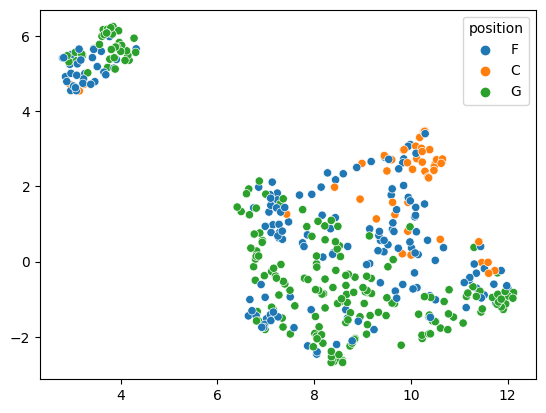

In [17]:
import umap.umap_ as umap

reducer = umap.UMAP(random_state = 42)
embedding = reducer.fit_transform(players_stats_agg.iloc[:,5:])

fig, ax = plt.subplots()
sns.scatterplot(embedding[:,0], embedding[:,1], hue=players_data['position'], legend='full')
cursor = mplcursors.cursor(hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(data_names[sel.index]))

plt.show()

# center anschauen -> Why Daniel Theis shown as F?

#players_cluster = players_stats_agg[embedding[:,0] < 0]['PLAYER_ID']
#[print(players_data[players_data['id'] == p]['player_names']) for p in players_cluster]

In [98]:
# pro position
pos = 'F'

data_pos = players_stats_agg[players_data['position'] == pos].iloc[:,5:]
data_names = list(players_data[players_data['position'] == pos]['player_names'])

reducer = TSNE() 
#reducer = umap.UMAP(random_state = 42)

X_embedded = tsne.fit_transform(data_pos)

fig, ax = plt.subplots()
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full') #ax.scatter(X_embedded[:,0], X_embedded[:,1])
#for i, txt in enumerate(data_names):
#    ax.annotate(txt, (X_embedded[:,0][i],  X_embedded[:,1][i]))
cursor = mplcursors.cursor(hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(data_names[sel.index]))

plt.show()

#players_cluster = players_stats_agg[players_data['position'] == pos]
#players_cluster = players_cluster[(X_embedded[:,0] > 75) & (X_embedded[:,1] > 20)]['PLAYER_ID']
#pl = [list(players_data[players_data['id'] == p]['player_names'])[0] for p in players_cluster]
#print(pl)

/Users/timbundert/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


In [75]:
#ind = players_data[players_data['id'] == get_playerID('Stephen Curry')].index.tolist()[0]
#display(players_stats_agg[players_stats_agg['PLAYER_ID'] == get_playerID('Stephen Curry')],
#        players_stats_agg[players_stats_agg['PLAYER_ID'] == get_playerID('Damian Lillard')])
#display(players_stats[players_stats['PLAYER_ID'] == get_playerID('Stephen Curry')],
#        players_stats[players_stats['PLAYER_ID'] == get_playerID('Damian Lillard')])

## Class definition

In [36]:
data_emb = copy.deepcopy(players_stats_agg.iloc[:, :5])
data_emb['embedded_1'] = embedding[:,0]
data_emb['embedded_2'] = embedding[:,1]

data_used = data_emb # players_stats_agg

In [37]:
class RecommendationEngine:
    def __init__(self, replacing_player):
        self.player_name = replacing_player        
        try:
            self.player_id = players_data[players_data["player_names"] == replacing_player]['id'].iloc[0]
        except IndexError:
            print("Please provide the full name of a valid active NBA player.")
        self.position = adj_position(commonplayerinfo.CommonPlayerInfo(self.player_id).get_data_frames()[0]['POSITION'][0])
        self.team = self.team_lastSeason()
            
    def recommend(self):   
        ids_samePosition = list(players_data[players_data["position"] == self.position]['id'])
        #stats = players_stats_agg[players_stats_agg['PLAYER_ID'].isin(ids_samePosition)] # get only players of same position
        stats = data_used # get players from all positions
        
        stats_repl_player = stats[stats['PLAYER_ID'] == self.player_id].iloc[:,5:] # get data from player to be replaced
        stats = stats[players_data['team'] != self.team] # exclude players from same team
        print(stats[stats['PLAYER_ID'] == self.player_id])
        stats_num = stats.iloc[:,5:]
        
        if stats_repl_player.shape[0] != 0:
        
            # https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html
            '''
            model = NearestNeighbors(n_jobs = -1).fit(stats_num)
            res_distances, res_players = model.kneighbors(stats_repl_player, return_distance = True)
            res_distances, res_players = res_distances[0], res_players[0]
            res_player_0 = res_players[0]
                
            res_player_id = stats.reset_index()['PLAYER_ID'][res_player_0]
            rec_player = players_data[players_data['id'] == res_player_id]['player_names'].iloc[0]
            closest_players = []
            for i in range(len(res_players)):
                id_player = stats.reset_index()['PLAYER_ID'][res_players[i]]
                closest_players.append({'player': players_data[players_data['id'] == id_player]['player_names'].iloc[0],
                                        'distance': res_distances[i]})
            '''
            
            closest_players = []
            closest_idx, closest_distances = self.closest_node(stats_repl_player, stats_num)
            for i in range(len(closest_idx)):
                id_player = stats.reset_index()['PLAYER_ID'][closest_idx[i]]
                closest_players.append({'player': players_data[players_data['id'] == id_player]['player_names'].iloc[0],
                                        'distance': closest_distances[i]})
            
            rec_player = closest_players[0]['player']
                
            
            print(f'Input Player: {self.player_name} (Team: {self.team})')
            print('Salary:')
            salary_input_player = self.player_salary(self.player_name)
            display(salary_input_player)
            
            self.plot_distance(closest_players)
            p_ids = [stats.reset_index()['PLAYER_ID'][closest_idx[i]] for i in range(len(closest_idx))]
            p_ids.append(self.player_id)
            self.plot_distance2(p_ids)

            
            print(f'\nRecommended Player: {rec_player}')
            print('Salary:')
            salary_rec_player = self.player_salary(rec_player)
            display(salary_rec_player)
            
            #print('-> Change in salary:')
            change_salary = self.change_salary(list(salary_input_player.iloc[0,1:]), list(salary_rec_player.iloc[0,1:]))
            #display(change_salary)
            
            #print('Salary Input Team:')
            team_salary = self.team_salary()
            #display(team_salary)
            
            limit_salary = self.limit_salary_team(team_salary)
        
            #print('New Salary Input Team:')
            new_team_salary = self.new_team_salary(change_salary, team_salary)
            #display(new_team_salary)

            # Take with caution because also many players still have 0 salary
            print(f"Change in projected luxury tax: {[(luxury_tax(new_team_salary.iloc[0, i]) - luxury_tax(team_salary.iloc[0, i])) for i in range(3, team_salary.shape[1])]}")
            
            visualize_capspace(team_salary.append(new_team_salary).append(limit_salary), 
                               ['Old Salary', f"New Salary by adding {rec_player}", 'Limit salary'],
                               self.team)

            return rec_player
        
        print("No data available for this player in the last season")
        pass
    
    
    def closest_node(self, node, nodes, topN = 5):
        node, nodes = np.asarray(node), np.asarray(nodes)
        distances = np.sum((nodes - node)**2, axis=1) # or L1: np.sum(np.abs(nodes - node), axis=1)
        topN_ids = np.argsort(distances)[: topN]
        #topN_dict = [{'player': players_data['player_names'][idx], 'distance': distances[idx]} for idx in topN_ids]  
#        print(distances[:topN + 1])
        return topN_ids[:topN + 1], np.sort(distances[:topN])
    
    def player_salary(self, rec_player):
        return players_salaries[players_salaries['player_names'] == rec_player]
    
    def change_salary(self, df_inputplayer, df_recplayer):
        # input - recommended
        change = [float(df_inputplayer[i]) - float(df_recplayer[i]) for i in range(1, len(df_inputplayer))] 
        return change
    
    def team_salary(self):
        # option with Commonplayerinfo (-> infos from this season (so, future))
        #data_rec_player = commonplayerinfo.CommonPlayerInfo(player_id=self.player_id) 
        # abb_team = list(data_rec_player.get_data_frames()[0]['TEAM_ABBREVIATION'])[0]
        
        abb_team = list(players_data[players_data['id'] == self.player_id]['team'])[0]
        return teams_salaries[teams_salaries['Abb'] == abb_team]
    
    def new_team_salary(self, change_salary, df_old_salary):
        df_new_salary = copy.copy(df_old_salary)
        for i in range(len(change_salary)):
            df_new_salary.iloc[0, 3+i] += change_salary[i]
        return df_new_salary
    
    
    def team_lastSeason(self):
        return list(players_data[players_data['id'] == self.player_id]['team'])[0]
    
    def limit_salary_team(self, team_salary):
        df_limit_salary = copy.copy(team_salary)
        for i in range(3, df_limit_salary.shape[1]):
            if df_limit_salary.iloc[0, i] > 0:
                pass
            else:
                df_limit_salary.iloc[0, i] *= 1.1 # may overdraw another 10 % -> oder via penalty function via betrag der negativität
        return df_limit_salary
    
    def plot_distance(self, dist_dict):
        #colors = ['blue', 'green', 'red']

        fig, ax = plt.subplots(figsize=(12, 5))
        x_values = [dist_dict[i]['distance'] for i in range(len(dist_dict))]
        x_values.append(0)
        y_values = (len(dist_dict)+1)*[0]
        colors = ['green']
        for i in range(len(y_values)-2):
            colors.append('blue')
        colors.append('red')
        
        names = [self.player_name]
        for i in range(len(dist_dict)):
            names.append(dist_dict[i]['player'])
        
        ax.scatter(x_values, y_values, color = colors, s = 70) #label = names
        #for i in range(len(x_values)):
        #    ax.scatter(x_values[i], y_values[i], label = names[i], color = colors[i], s = 70) #label = names
            
        ax.set(title = f'Recommendation system for {self.player_name}', xlabel = "Distance")
        ax.axes.get_yaxis().set_visible(False)
        right_side = ax.spines["right"]
        right_side.set_visible(False)
        left_side = ax.spines["left"]
        left_side.set_visible(False)
        top_side = ax.spines["top"]
        top_side.set_visible(False)

       # plt.xticks(x, " ")
        
        #ax.legend(names)

        ax.annotate(self.player_name, (x_values[-1], y_values[-1]), xytext = (x_values[-1], y_values[-1] + 0.02), arrowprops = {'arrowstyle': '->'} )
        for i in range(len(dist_dict)):
            ax.annotate(dist_dict[i]['player'], (x_values[i], y_values[i]), xytext = (x_values[i], y_values[i] + 0.02*np.power(-1, i)), arrowprops = {'arrowstyle': '->'} )
    
        return plt.show()
    
    def plot_distance2(self, p_idxs):
        
        colors = ['green']
        for i in range(len(p_idxs)-2):
            colors.append('blue')
        colors.append('red')
            
        idxs = [(data_used.index[data_used['PLAYER_ID'] == p]).tolist()[0] for p in p_idxs]
        player_names = [list(players_data[players_data['id'] == p]['player_names'])[0] for p in p_idxs]

        fig, ax = plt.subplots(figsize=(12, 5))
        ax.set(title = f'Recommendation system for {self.player_name}', xlabel = "Distance")

        for i in range(len(p_idxs)):
            ax.scatter(data_used.iloc[idxs[i], 5], data_used.iloc[i,6], 
                       #label = players_data[players_data['id'] == r[i]], 
                       color = colors[i], s = 70)

            ax.annotate(player_names[i], 
                        (data_used.iloc[idxs[i], 5], data_used.iloc[i,6]), xytext = (data_used.iloc[idxs[i], 5], data_used.iloc[i,6] + 0.5*np.power(-1, i)), arrowprops = {'arrowstyle': '->'} ) 
    
        return plt.show()

## Exemplary execution

Empty DataFrame
Columns: [PLAYER_ID, SEASON_ID, LEAGUE_ID, TEAM_ID, TEAM_ABBREVIATION, embedded_1, embedded_2]
Index: []
Input Player: LeBron James (Team: LAL)
Salary:


,id,player_names,2021/22,2022/23,2023/24,2024/25
4,2544,LeBron James,0.0,0.0,0.0,0.0


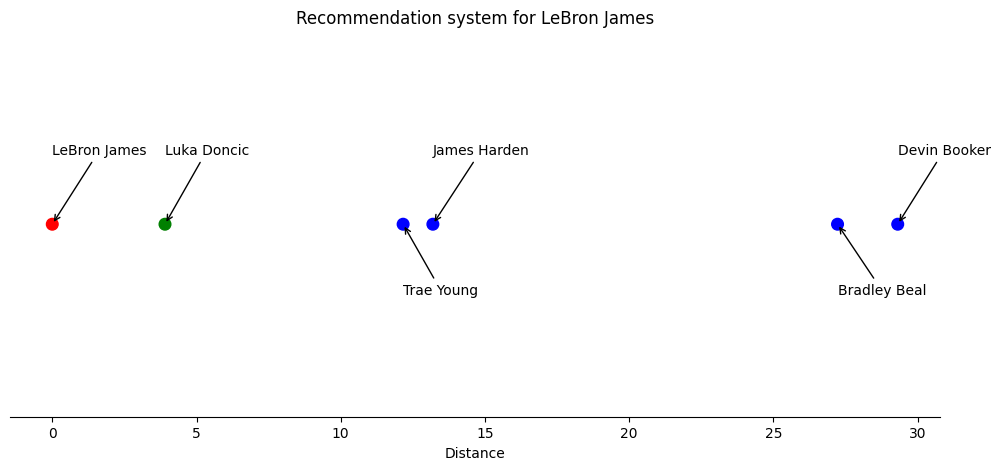

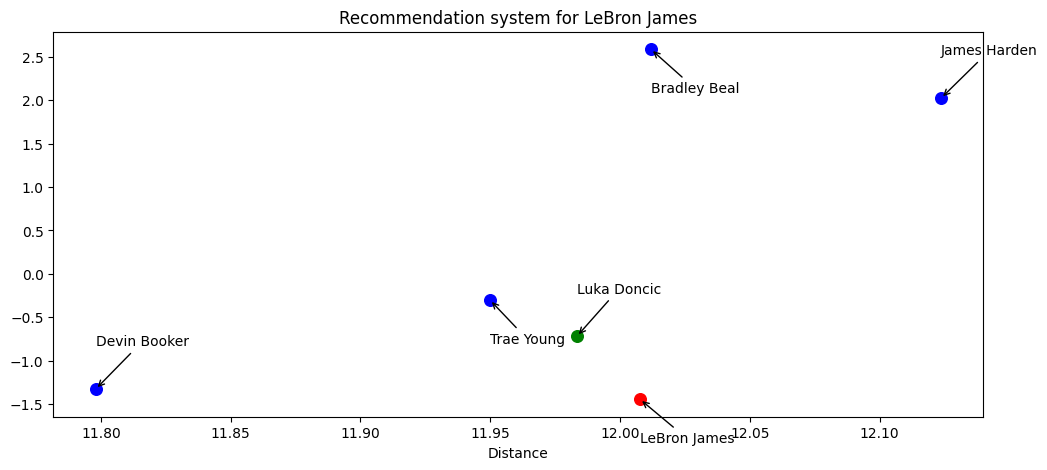


Recommended Player: Luka Doncic
Salary:


,id,player_names,2021/22,2022/23,2023/24,2024/25
124,1629029,Luka Doncic,38556000.0,41412000.0,44268000.0,47124000.0


Change in projected luxury tax: [243166724.0, 271435069.5, 282108832.5, 0]


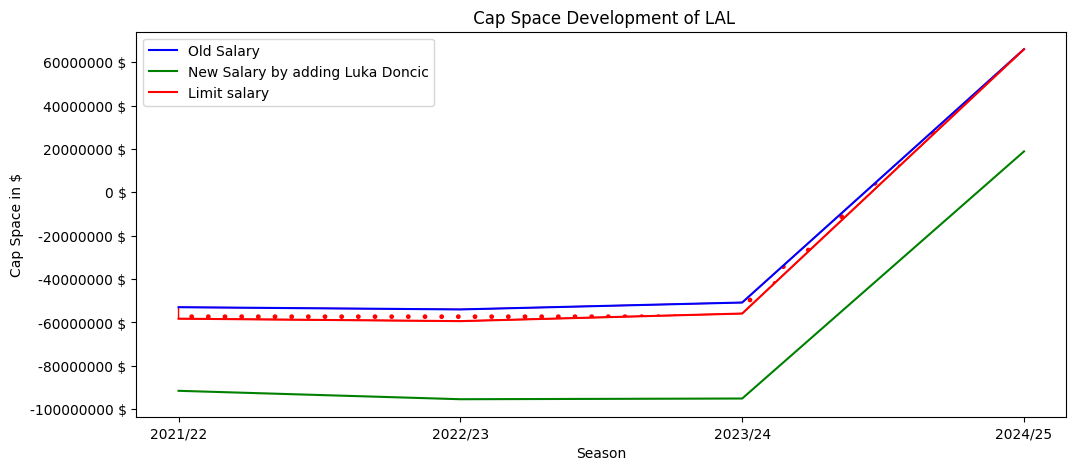

'Luka Doncic'

In [38]:
sample_recommendation = RecommendationEngine("LeBron James") # Joel Embiid, ...
sample_recommendation.recommend()

# TO-DO

### Diverse
- finde implementierten cap space mehrmals im Internet? **-> jein**
- implement Cap constraint (entforcen) **-> nur Notiz über Luxury Tax**
- models vorher berechnen & nur most similar player rausgeben?
- visualization of distance of single player? -> embedding? 2D?
- doch diese saison mit rein nehmen und predictions für laufende/kommende Saison machen? **-> nein**
- Reinforcement Learning benutzen?
- deployment in Docker: https://www.youtube.com/watch?v=cQzqaKw5y2I ?
- change average of last 3 seasons to: 6/10, 3/10, 1/10? **-> check**
- delete limit salary in graph?
- unnötige csv files löschen
- feature representation: weights from DNN; spectral clustering  **-> check**
- \*list -> unpack
- can split into offensive & defensive similarity -> weigh offensive & defensive similarity according to user input -> provide e.g., 3 options 
- bei input mal schauen: pd.read_csv("./data/season_prediction/schedule.csv", dtype={'GAME_ID': str})
- doppelter LeBron
- eigenen Branch -> jeder eine Seite machen (Startpunkt: erstes Dashboard; via MultiSelector)

### Finn:
- add physical attributes? add more features to prediction? (see towardsDS article)
- Normalize data -> pro feature? Geteilt durch spiele?  **-> check**
- spectral embedding & dann knn  **-> check**

### Option 1: ähnlicher, aber effizienterer Pick
- more complex neighbor model  **-> check**
-* normalize data  **-> check**
-* k-means  **-> not useful in this context**
- add regressed efficiency rating from Finn

Alternatives: [Hierarchical clustering](https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/),
[Overview clustering techniques](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py), 
[Feature agglomeration](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.FeatureAgglomeration.html#sklearn.cluster.FeatureAgglomeration),
[DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html),
[K Neigbors Graph](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.kneighbors_graph.html),
[Self-organizing Maps](https://stackabuse.com/self-organizing-maps-theory-and-implementation-in-python-with-numpy/)

### Option 2: best fit
- welcher am besten mit anderen 4 Spielern passt —> machen evtl mehr punkte, assists als typischer spieler auf der position (10 most similar players) —> brauchen als neuen spieler jmd der mehr assists macht
- Via boxplot: starting 5
- auf selbes Model beziehen (imaginary player einwerfen)
- via softmax gewichten

## Finn:
- aggregate via sum() oder mean()?
- drop Age? what variables to optimise?

In [28]:
boxscores = pd.read_csv('data/season_prediction/boxscores_20_21.csv')
#boxscores.iloc[:20, :13]

In [29]:
from collections import Counter

def starting_five(team_abb: str, names = False):
    positions = {'F': 2, 'C': 1, 'G': 2}
    data_team = boxscores[(boxscores['TEAM_ABBREVIATION'] == team_abb) & (boxscores['START_POSITION'].notnull())].loc[:, ['PLAYER_ID', 'START_POSITION']]
    players_team = list(players_data[players_data['team'] == team_abb]['id'])
    
    if list(data_team['START_POSITION'].unique()) != list(positions.keys()):
        print('Error')
        
    players_pos = list()
    for pos in positions.keys():
        data_team_pos = data_team[data_team['START_POSITION'] == pos]['PLAYER_ID'].astype(int)
        count_pos = Counter(data_team_pos)
        count_pos = dict(sorted(count_pos.items(), key=lambda item: item[1], reverse=True))
        del_players = []
        for i in range(len(count_pos)):
            player = list(count_pos.keys())[i]
            if player not in players_team: # only keep players which are still active and belong to team at end of last season
                del_players.append(player)
        
        for p in del_players:
            del count_pos[p]
        players_pos.append(count_pos)
        
            
    # delete player from positions where he played less frequently
    players = [list(players_pos[i].keys()) for i in range(len(positions))]
    players = dict(Counter([x for l in players for x in l]))
    dupl_players = [k for k,v in players.items() if v > 1]
    for dupl_pl in dupl_players:
        counts = []
        for i in range(len(players_pos)):
            try:
                counts.append(players_pos[i][dupl_pl])
                
            except KeyError:
                counts.append(0)
        keep_pos = np.argmax(counts)
        for j in range(len(players_pos)):
            if j == keep_pos:
                continue
            try:
                del players_pos[j][dupl_pl]
                
            except KeyError:
                continue
    
    starting_five = {}
    for i in range(len(positions)):
        pos = list(positions.keys())[i]
        dict_pos = players_pos[i]
        pos_players = list(dict_pos.keys())[:(positions[pos])]
        for i in range(len(pos_players)):
            if names:
                name = list(players_data[players_data['id'] == pos_players[i]]['player_names'])[0]
                starting_five[name] = pos 
            
            else:
                starting_five[pos_players[i]] = pos                               
            
    return starting_five

# Spieler die retired sind in starting 5 mit anderen Spielern von Team ersetzen

In [31]:
starting_five('LAL', names = False)

{2544: 'F', 203076: 'F', 203083: 'C', 203484: 'G', 203471: 'G'}

In [32]:
performance_teams = np.zeros((teams_data.shape[0], len(players_stats_agg.columns)-5))
for i in range(teams_data.shape[0]):
    team_abb = list(teams_data['abbreviation'])[i]
    start_five_team = list(starting_five(team_abb, names = False).keys())
    data_team = pd.concat([players_stats_agg[players_stats_agg['PLAYER_ID'] == start_five_team[i]] for i in range(len(start_five_team))])
    performance_teams[i, :] = np.array(data_team.iloc[:,5:].sum(axis=0))

In [33]:
maxs = np.amax(performance_teams, axis=0) 

# oder: umdrehen bei import via - die column?
maxs[0] = np.amin(performance_teams[:,0]) # PLAYER_AGE
maxs[19] = np.amin(performance_teams[:,19]) # PF
maxs[20] = np.amin(performance_teams[:,20]) # TOV

maxs = maxs
display(maxs)

array([-5.1156875 ,  5.45435283,  8.70570425,  3.45649757,  6.00392465,
        5.70781621,  3.7455292 ,  4.09781133,  3.81514   ,  3.58286709,
        6.75555641,  6.90113049,  3.68049033,  2.30959473,  4.3378403 ,
        3.74937724,  5.6850351 ,  4.47399481,  3.04996117, -0.28814428,
       -3.13444031,  6.45389309])

In [34]:
rep_player_id = 2544 # player to be replaced

team_abb = list(players_data[players_data['id'] == 203083]['team'])[0]
start_five_team = list(starting_five(team_abb, names = False).keys())
start_five_team.remove(rep_player_id)
data_team = pd.concat([players_stats_agg[players_stats_agg['PLAYER_ID'] == start_five_team[i]] for i in range(len(start_five_team))])

#data_team_agg = copy.deepcopy(data_team)
#data_team_agg.iloc[:, 0] = 'aggregated'
#data_team_agg.iloc[:, 3] = list(teams_data[teams_data['abbreviation'] == team_abb]['id'])[0]
#data_team_agg.iloc[0, 5:] = data_team.iloc[:,5:].sum(axis=0)
data_team = np.abs(np.array(data_team.iloc[:,5:].sum(axis=0)))

display(data_team)

array([0.69900831, 3.07580655, 3.91642727, 2.3156262 , 3.8013556 ,
       3.73218658, 2.0028375 , 1.20669634, 1.19702027, 0.56187613,
       4.4961043 , 4.97037117, 2.02165617, 2.47629006, 3.12388962,
       3.08548277, 0.95535269, 3.53529424, 2.43042889, 3.95577673,
       0.51792548, 3.69429548])

In [35]:
diff = np.abs(maxs - data_team)

In [36]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

s = softmax(diff)
ideal_player = s * maxs
emd_ideal_player = reducer.transform(ideal_player.reshape(1, -1))

# pro Attribut um x% verbessern

In [175]:
emd_ideal_player

array([[7.670623  , 0.19169697]], dtype=float32)

In [39]:
fig, ax = plt.subplots()
ax.scatter(embedding[:,0], embedding[:,1], c='blue')
cursor = mplcursors.cursor(hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(data_names[sel.index]))
ax.scatter(emd_ideal_player[0,0], emd_ideal_player[0,1], c='green')
#plt.legend()

plt.show()

# players_data['position']
# drop LeBron from embedding & then scatter each point individually
# compare position of artifical player to LeBron's position

# aktuell: bester prospect
# regler für user einbinden

# seperate modell wenn ohne Alter-Attribut

In [149]:
players_stats_agg.columns

Index(['PLAYER_ID', 'SEASON_ID', 'LEAGUE_ID', 'TEAM_ID', 'TEAM_ABBREVIATION',
       'PLAYER_AGE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

### Meeting Jonathan

- vorschlagen welche replaced
- bei 0: gestrichelt
- Klay Thompson: Unsicherheit zeigen
- Starting 5 zeigen
- Modelle vergleichen: wie läuft wenn nicht auf Position begrenze?
- Imaginären Spieler erschaffen in höher dim Space als differenz von 4 spielern zu durchschnitt von playoff teams? (gibt 2-3 verschiedene Spielstyles) -> auch Style vorhersagen
- Was potentielle Vorteile von anderen komplexeren Modellen in diesem Datenproblem (e.g. T-SNE), wie ist performance (eyeballing)? (e.g. baut t-sne als besserer KNN auf?
- wie berechnet sich luxury tax? (keine Grenze einführen & nur informativ?)

### Zwischenpräsentation

- Thema einführen
- Was haben wir gemacht? Welche Herausforderungen?
- Datenbeschaffung
- Vorläufige Ergebnisse
- Grobe App stehen
- Präsentation zur Erklärung
- Ausblick

- 15-20 Minuten Präsentation
- Ihm Zeigen -> entspricht Vorstellungen?

In [ ]:
stats_lastSeason.columns # -> adjust data by dividing by number of games?